# Dog Breed - Xception ensemble

In [67]:
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from keras.preprocessing.image import load_img, img_to_array, flip_axis
from keras.applications import xception
from keras.utils import to_categorical

from keras.layers import Input, Lambda, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.cross_validation import StratifiedKFold

%matplotlib inline

## Load training data

In [106]:
labels = pd.read_csv('./data/labels.csv')

In [107]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [108]:
n = len(labels)
num_classes = len(labels.breed.unique())
img_size = (299, 299)

In [109]:
id_to_label = {i: label for i, label in enumerate(sorted(labels.breed.unique()))}
label_to_id = {label: i for i, label in id_to_label.items()}

In [104]:
def load_training(labels_path, img_size):
    """Load training data into an array."""
    
    X = np.zeros((n,) + img_size + (3,), dtype=np.uint8)
    Y = np.zeros((n, num_classes), dtype=np.uint8)

    for i, row in tqdm_notebook(enumerate(labels.itertuples()), total=n):
        _, item_id, label = row 

        img = Image.open(f'./data/train/{item_id}.jpg').resize(img_size)

        label_id = label_to_id[label]

        X[i] = np.asarray(img)
        Y[i][label_id] = 1
        
    return X, Y

In [105]:
X, Y = load_training('./data/labels.csv', img_size)

HBox(children=(IntProgress(value=0, max=10222), HTML(value='')))

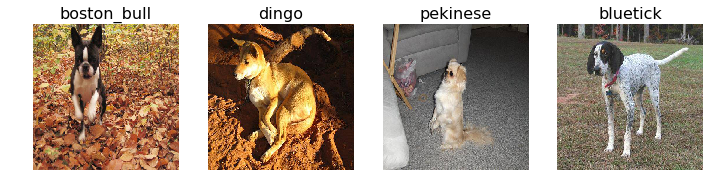

In [7]:
f = plt.figure(figsize=(12, 6))

for i in range(4):
    sp = f.add_subplot(2, 4, i+1)
    sp.axis('Off')
    sp.set_title(id_to_label[np.argmax(Y[i])], fontsize=16)
    plt.imshow(X[i])

In [69]:
def get_bottleneck_features(X, batch_size=128, img_size=(299, 299)):
    input_shape = img_size + (3,)

    base_model = xception.Xception(
        include_top=False, input_shape=input_shape, weights='imagenet')

    inp = Input(input_shape)
    x = Lambda(xception.preprocess_input, name='preprocessing')(inp)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)

    cnn_model = Model(inp, outputs=x)

    return cnn_model.predict(X, batch_size=128, verbose=1)


def get_model(shape, num_classes):
    inputs = Input(shape)
    x = Dropout(0.5)(inputs)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [71]:
features = get_features(X)

10222/10222 [==============================] - 217s 21ms/step


## Xception

In [73]:
model = get_model(features.shape[1:], num_classes)
    
callbacks = [
    ReduceLROnPlateau(patience=2, verbose=1),
    EarlyStopping(patience=6)]

res = model.fit(
    features, Y, batch_size=64, epochs=40, validation_split=0.1, callbacks=callbacks)

Train on 9199 samples, validate on 1023 samples
Epoch 1/40
9199/9199 [==============================] - 4s 395us/step - loss: 1.7404 - acc: 0.7258 - val_loss: 0.5338 - val_acc: 0.9032
Epoch 2/40
9199/9199 [==============================] - 1s 73us/step - loss: 0.4322 - acc: 0.9023 - val_loss: 0.3677 - val_acc: 0.9091
Epoch 3/40
9199/9199 [==============================] - 1s 72us/step - loss: 0.3228 - acc: 0.9174 - val_loss: 0.3267 - val_acc: 0.9052
Epoch 4/40
9199/9199 [==============================] - 1s 73us/step - loss: 0.2690 - acc: 0.9260 - val_loss: 0.3047 - val_acc: 0.9071
Epoch 5/40
9199/9199 [==============================] - 1s 73us/step - loss: 0.2351 - acc: 0.9330 - val_loss: 0.2980 - val_acc: 0.9091
Epoch 6/40
9199/9199 [==============================] - 1s 73us/step - loss: 0.2109 - acc: 0.9405 - val_loss: 0.2921 - val_acc: 0.9071
Epoch 7/40
9199/9199 [==============================] - 1s 73us/step - loss: 0.1923 - acc: 0.9460 - val_loss: 0.2894 - val_acc: 0.9110
Epoch 

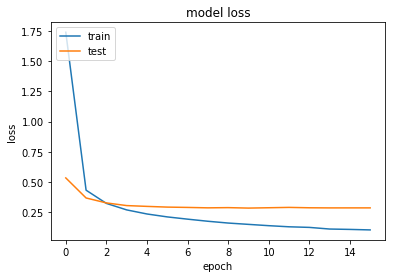

In [74]:
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.title(f'model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Trains in < 30 seconds and should get in the top 30% of the leaderboard. Not bad.

## Xception Ensemble with 10 folds

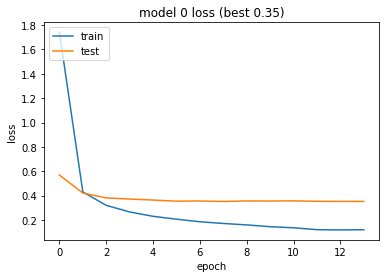

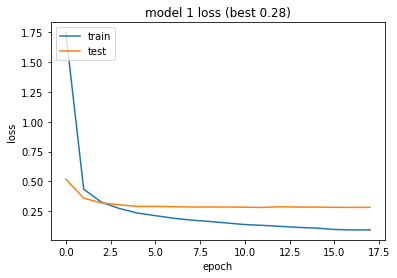

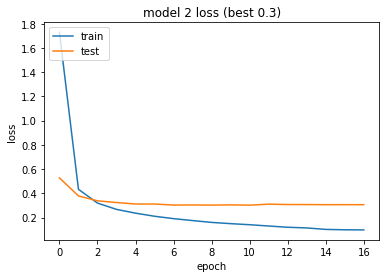

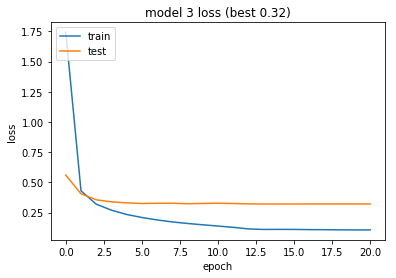

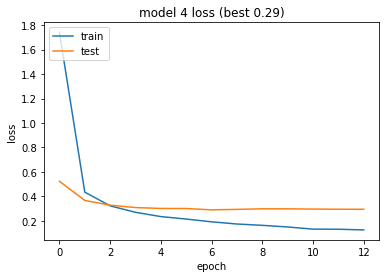

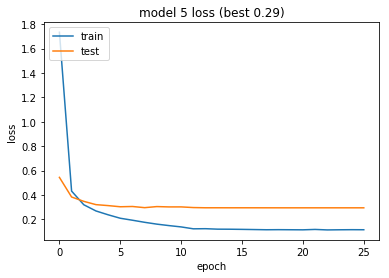

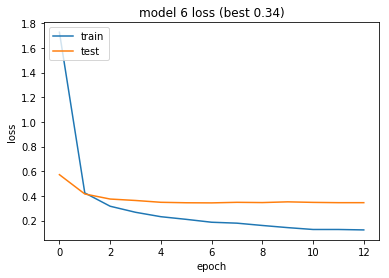

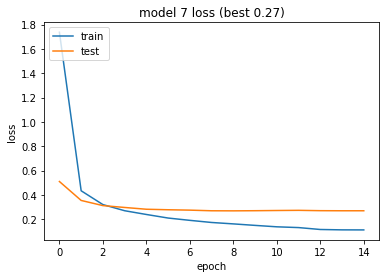

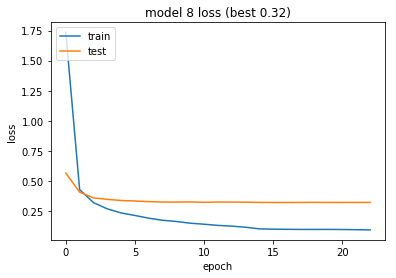

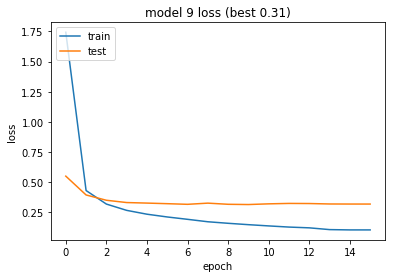

In [87]:
skf = StratifiedKFold(np.argmax(Y, axis=1), n_folds=10, shuffle=True)

for i, (train, dev) in enumerate(skf):
    model_path = f'./checkpoints/xception_ens_{i}.h5'
    callbacks = [
        ModelCheckpoint(model_path, save_best_only=True),
        ReduceLROnPlateau(patience=2, verbose=False),
        EarlyStopping(patience=6)]
    
    model = get_model(features.shape[1:], num_classes)
    
    features_train, features_dev = features[train], features[dev]
    y_train, y_dev = Y[train], Y[dev]
    res = model.fit(
        features_train, y_train, batch_size=64, epochs=40,
        validation_data=(features_dev, y_dev), verbose=False, callbacks=callbacks)
    
    best_loss = round(min(res.history['val_loss']), 2)
    plt.plot(res.history['loss'])
    plt.plot(res.history['val_loss'])
    plt.title(f'model {i} loss (best {best_loss})')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [89]:
def get_test_inputs(sample_df):
    n_test = len(sample_df)
    X_test = np.zeros((n_test,) + img_size + (3,), dtype=np.uint8)
    for i, row in tqdm_notebook(enumerate(sample_df.itertuples()), total=n_test):
        item_id = row.id

        img = Image.open(f'./data/test/unknown/{item_id}.jpg').resize(img_size)

        label_id = label_to_id[label]

        X_test[i] = np.asarray(img)
        
    return X_test

In [90]:
sample_df = pd.read_csv('./data/sample_submission.csv')

In [91]:
X_test = get_test_inputs(sample_df)

HBox(children=(IntProgress(value=0, max=10357), HTML(value='')))

In [92]:
test_features = get_features(X_test)

10357/10357 [==============================] - 220s 21ms/step


In [96]:
model = get_model(features.shape[1:], num_classes)

predictions = []

for i in range(10):
    model.load_weights(f'./checkpoints/xception_ens_{i}.h5')
    p = model.predict(test_features)
    predictions.append(p)
    
avg_preds = np.stack(predictions).mean(axis=0)

In [97]:
for i in range(num_classes):
    sample_df[id_to_label[i]] = avg_preds[:,i]

In [98]:
sample_df.to_csv('./submissions/xception_ensemble.csv', index=None)

That gets around 0.30191 on the leaderboard which puts me at position 229.